In [51]:
#Libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

### Definition of constant values

In [52]:
# Cardiac cycles per minute
bpm = 50

# Period of each cardiac cycle in seconds
t_bit = 60/bpm

# Period of systole in seconds
t_syst = (2/5)*t_bit

# Maximum putput volume of blood for each cycle in mL
max_vol_output = 300 


### Definition of flow equation

In [53]:
def flow_diff0(t):
    t_val = t%t_bit
    
    if t_val <= t_syst:
        return max_vol_output*np.sin(np.pi*t_val/t_syst)
    else:
        return 0
    
def flow_diff1(t):
    t_val = t%t_bit
    
    if t_val <= t_syst:
        return max_vol_output*(np.pi/t_syst)*np.cos(np.pi*t_val/t_syst)
    else:
        return 0

def flow_diff2(t):
    t_val = t%t_bit
    
    if t_val <= t_syst:
        return (-1)*max_vol_output*((np.pi/t_syst)**2)*np.sin(np.pi*t_val/t_syst)
    else:
        return 0

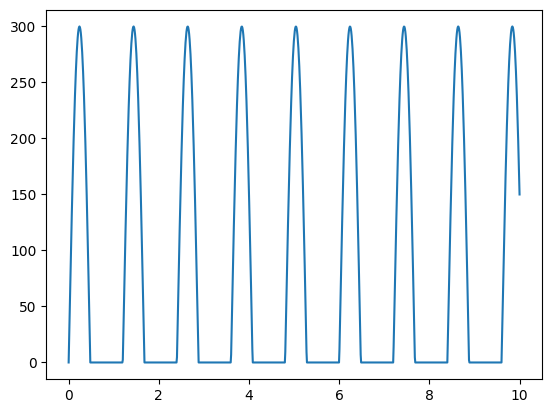

In [54]:
arr_t = np.linspace(0,10,1000)
arr_i = np.array([flow_diff0(t) for t in arr_t])

plt.plot(arr_t,arr_i)
plt.show()

In [55]:
# systemic peripheral resistance in (mmHg/cm^3/sec)
r = 0.9

# systemic arterial compliance in (cm^3/mmHg)
c = 1.0666

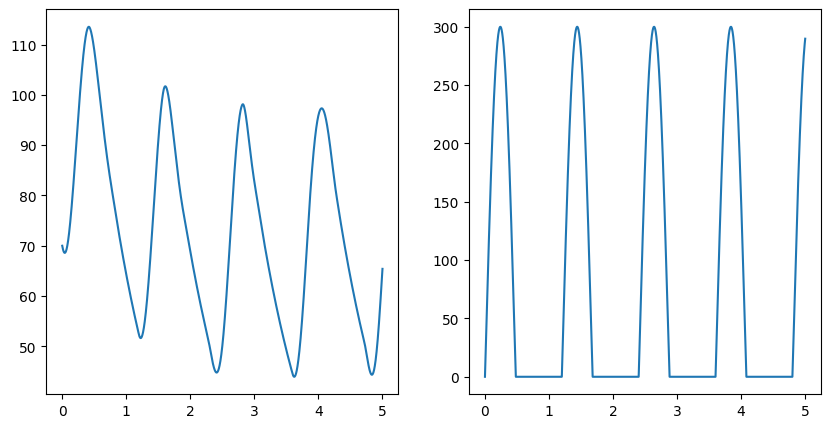

In [56]:
def func_wink2elements(t,v):
    dvdt = (1/c)*flow_diff0(t) - (1/(r*c))*v 
    return dvdt

arr_t = np.linspace(0,5,5000)
arr_i = np.array([flow_diff0(t) for t in arr_t])
v_init = 70 #mmHg

sol = solve_ivp(lambda t, v: func_wink2elements(t,v),t_span=[arr_t[0],arr_t[-1]],y0=[v_init],t_eval=arr_t)


fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,2,1)
ax.plot(sol.t, sol.y[0])

ax = fig.add_subplot(1,2,2)
ax.plot(sol.t, arr_i)

plt.show()

In [57]:
# systemic peripheral resistance in (mmHg/cm^3/sec)
rp = 1.05

# systemic characteristic resistance in (mmHg/cm^3/sec)
rc = 0.057

# systemic arterial compliance in (cm^3/mmHg)
c = 1.37

# systemic arterial intertia in (mmHg/cm^3/s^2)
l = 0.0070

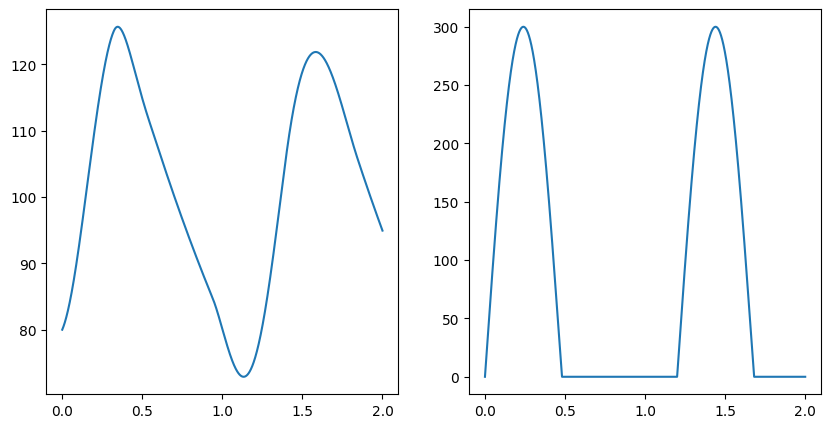

In [58]:
def func_wink3elements(t,v):
    
    b0 = (1+rc/rp)
    b1 = c*rc
    
    a0 = 1/rp
    a1 = c
    
    dvdt = (1/a1)*(b0*flow_diff0(t) + b1*flow_diff1(t) - a0*v)
    return dvdt

arr_t = np.linspace(0,2,5000)
arr_i = np.array([flow_diff0(t) for t in arr_t])
v_init = 80 #mmHg

sol = solve_ivp(lambda t, v: func_wink3elements(t,v),t_span=[arr_t[0],arr_t[-1]],y0=[v_init],t_eval=arr_t)


fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,2,1)
ax.plot(sol.t, sol.y[0])

ax = fig.add_subplot(1,2,2)
ax.plot(sol.t, arr_i)

plt.show()

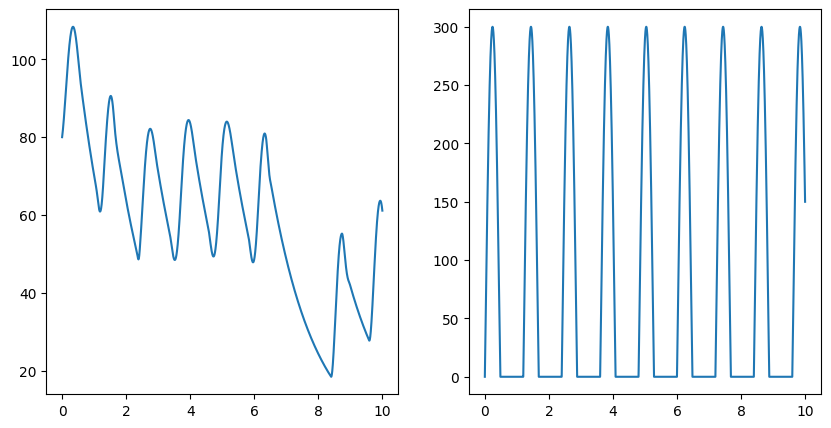

In [60]:
def func_wink3elements(t,v):
    
    b0 = (1+rc/rp)
    b1 = c*rc + l/rp
    b2 = l*c
    
    a0 = 1/rp
    a1 = c
    
    dvdt = (1/a1)*(b0*flow_diff0(t) + b1*flow_diff1(t) + b2*flow_diff2(t) - a0*v)
    return dvdt

arr_t = np.linspace(0,10,5000)
arr_i = np.array([flow_diff0(t) for t in arr_t])
v_init = 80 #mmHg

sol = solve_ivp(lambda t, v: func_wink3elements(t,v),t_span=[arr_t[0],arr_t[-1]],y0=[v_init],t_eval=arr_t)


fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,2,1)
ax.plot(sol.t, sol.y[0])

ax = fig.add_subplot(1,2,2)
ax.plot(sol.t, arr_i)

plt.show()